In [320]:
import pandas as pd
from sklearn import (datasets, decomposition, ensemble, 
                     metrics, model_selection, preprocessing)
import matplotlib.pyplot as plt
import numpy as np
from pca import pca

In [321]:
all_data = pd.read_excel('alldata.xlsx')
dr_data = pd.read_excel('drdata.xlsx')
dr_q = pd.read_excel('drq.xlsx')
tv2_data = pd.read_excel('tv2data.xlsx')
tv2_q = pd.read_excel('tv2q.xlsx')
elected_data = pd.read_excel('electeddata.xlsx')

In [322]:
tv2_data['navn'].value_counts().where(lambda x : x > 1)

Marina Fløjgaard Andersen    2.0
Kasper Søstrøm Müller        NaN
Preben Friis-Hauge           NaN
Rikke Tangaa                 NaN
Tilde Holch Duedahl          NaN
                            ... 
Rajesh Holmen                NaN
Rashid Ali                   NaN
Sazan Garmiyani              NaN
Sikandar Siddique            NaN
Chresten H. Ibsen            NaN
Name: navn, Length: 961, dtype: float64

There are two people in tv2 answere that have the same name. But they are not in the same party. The one from Alternativet is not in the dr dataset. So this can be ignored. 

In [323]:
tv2_data.loc[tv2_data['navn'] == 'Marina Fløjgaard Andersen']

,1a,1b,2a,2b,3a,3b,4a,4b,5a,5b,...,10a,10b,11a,11b,12a,12b,parti,navn,storkreds,alder
302,-2,-1,2,2,2,0,0,-2,-2,0,...,0,-2,-2,0,2,-2,Moderaterne,Marina Fløjgaard Andersen,Københavns Storkreds,46
811,2,2,2,2,-2,0,0,0,0,2,...,-2,0,0,2,2,-2,Alternativet,Marina Fløjgaard Andersen,Vestjyllands Storkreds,49


In [324]:
dr_data.loc[dr_data['navn'] == 'Marina Fløjgaard Andersen']

,530,531,533,534,535,537,538,540,541,543,...,552,553,555,556,557,559,561,563,navn,parti
166,1,1,1,-2,2,2,-2,2,-2,2,...,1,-2,-1,2,-1,1,-1,-2,Marina Fløjgaard Andersen,Moderaterne


There are no two people in dr data that have the same name. 

In [325]:
dr_data['navn'].value_counts().where(lambda x : x > 1)

Lars Philipsen Prahm         NaN
Benny Engelbrecht            NaN
Christian Lorenzen           NaN
Dan Foss Kragh               NaN
Birgitte Klippert            NaN
                              ..
Lene Burchardt               NaN
Lene Brix Kjelgaard Jensen   NaN
Julius Bjørn Honoré          NaN
Steffen Holme Helledie       NaN
Gunvor Wibroe                NaN
Name: navn, Length: 904, dtype: float64

![Alt text](image-1.png)

In [326]:
color_dictionary = {
    "Socialdemokratiet": "#b32722", 
    "Radikale Venstre": "#713280",
    "Det Konservative Folkeparti": "#9eba27",
    "Nye Borgerlige": "#054f5c",
    "Socialistisk Folkeparti": "#dd0878",
    "Liberal Alliance": "#21c6cf",
    "Kristendemokraterne": "#bababa",
    "Moderaterne": "#6c39e5",
    "Dansk Folkeparti": "#f3cd41",
    "Frie Grønne, Danmarks Nye Venstrefløjsparti": "#00e66a",
    "Venstre": "#006697",
    "Danmarksdemokraterne": "#8ac3ff",
    "Enhedslisten": "#ed8019",
    "Alternativet": "#2a8f39"
}

We remove the Marina Flojgaard Andresen from Alternativet party from the tv2 data. Then we join the two datasets on name, keeping only those that occure in both datasets. 

In [327]:
tv2_data.drop(tv2_data[(tv2_data['navn']=='Marina Fløjgaard Andersen') & (tv2_data['parti']=='Alternativet')].index, inplace=True)
tv2_data.loc[tv2_data['navn'] == 'Marina Fløjgaard Andersen']

,1a,1b,2a,2b,3a,3b,4a,4b,5a,5b,...,10a,10b,11a,11b,12a,12b,parti,navn,storkreds,alder
302,-2,-1,2,2,2,0,0,-2,-2,0,...,0,-2,-2,0,2,-2,Moderaterne,Marina Fløjgaard Andersen,Københavns Storkreds,46


In [328]:
#join tv2_data and dr_data on 'navn' and 'parti', keeping the 'parti' and 'alder'. 

tv2_dr_data = tv2_data.merge(dr_data, on=['navn', 'parti'], how='inner')
tv2_dr_data['parti'].value_counts()

Det Konservative Folkeparti                    98
Socialdemokratiet                              87
Venstre                                        84
Enhedslisten                                   74
Liberal Alliance                               70
Socialistisk Folkeparti                        70
Radikale Venstre                               67
Alternativet                                   67
Nye Borgerlige                                 51
Dansk Folkeparti                               49
Kristendemokraterne                            42
Moderaterne                                    42
Danmarksdemokraterne                           37
Frie Grønne, Danmarks Nye Venstrefløjsparti    26
Løsgænger                                       3
Name: parti, dtype: int64

Removing Løsgænger from the list as they are not part of any political party. 

In [329]:
tv2_dr_data.drop(tv2_dr_data[tv2_dr_data['parti']=='Løsgænger'].index, inplace=True)

## Preprocessing

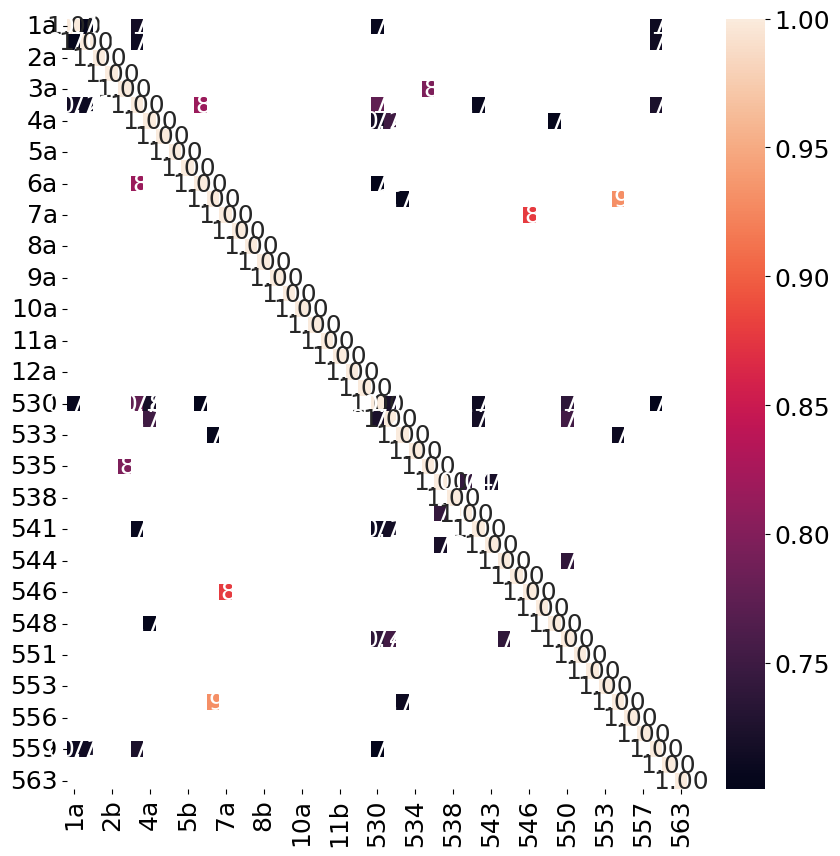

In [330]:
correlation = tv2_dr_data.copy()
correlation.drop(columns=['navn', 'alder', 'parti', 'storkreds'], inplace=True)
# plot correlation matrix with seaborn for only those with correlation higher than 0.7
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(correlation.corr()[correlation.corr() > 0.7], annot=True, fmt=".2f")
plt.show()


As we can see, there are some question, that are highly correlated. There are too many features to visually display this accurately. We will use an automatic algorithm to remove those that are highly correlated. We will not remove those that correlate highly with y, parti is excluded. 

In [331]:
# before removing correlation
correlation.shape[1]

49

In [332]:
# Create correlation matrix
corr_matrix = correlation.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
correlation.drop(to_drop, axis=1, inplace=True)

In [333]:
# after removing correlation 0.9
correlation.shape[1]

47

In [334]:
# Create correlation matrix
corr_matrix = correlation.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
correlation.drop(to_drop, axis=1, inplace=True)

In [335]:
# after removing correlation 0.8
correlation.shape[1]

42

In [336]:
# Create correlation matrix
corr_matrix = correlation.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop features 
correlation.drop(to_drop, axis=1, inplace=True)

In [337]:
# after removing correlation 0.7
correlation.shape[1]

31

## PCA

X is all the answers (-2, -1, 0, 1, 2) to the questions

y is all the parties

colors are the colors of the parties

In [338]:
#X = tv2_dr_data.copy()
#X.drop(columns=['navn', 'alder', 'parti', 'storkreds'], inplace=True)
X = correlation.copy()


In [339]:
y = tv2_dr_data['parti'].copy()

In [340]:
colors = [color_dictionary[parti] for parti in y]

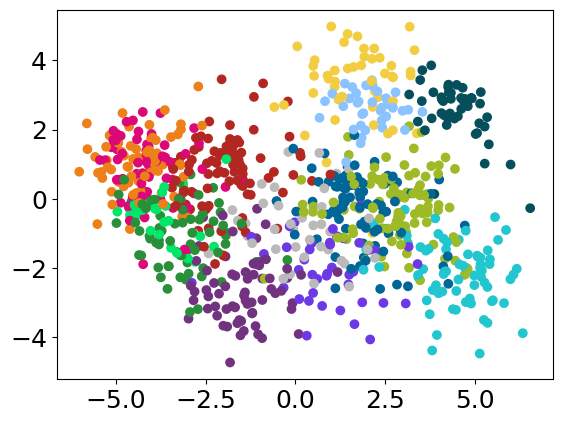

In [341]:
X_preprocessed = preprocessing.StandardScaler().fit_transform(X)
pca2d = decomposition.PCA(n_components=2)
res1 = pca2d.fit_transform(X_preprocessed)
plt.scatter(res1[:, 0], res1[:, 1], c=colors)

The first plot is when data is preprocessed, the second is pure. It seems like it mirrors and shifts the data a bit. 

## Most crutial questions

In [342]:
number_of_components = pca2d.components_.shape[0]
most_important = [np.abs(pca2d.components_[i]).argmax() for i in range(number_of_components)]
most_important_ids = X.columns[most_important]
most_important_ids

Index(['4a', '551'], dtype='object')

The questions with id 551 and 4a are the most important ones. 

In [343]:
dr_q.loc[dr_q['ID'] == 551]['Question'].values[0]

'Der skal være permanent grænsekontrol mellem Danmark og Tyskland'

'There must be permanent border control between Denmark and Germany'

In [344]:
tv2_q.loc[tv2_q['id'] == '4a']['question'].values[0]

'Den økonomiske ulighed i det danske samfund bør mindskes.'

'The economic inequality in Danish society should be reduced.'

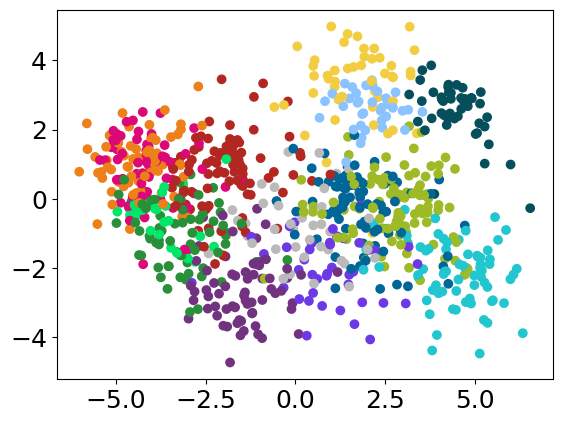

In [345]:
plt.scatter(res1[:, 0], res1[:, 1], c=colors)
plt.show()


[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [31] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [25] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [31] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[25]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 25 Principal Components explain [96.29%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

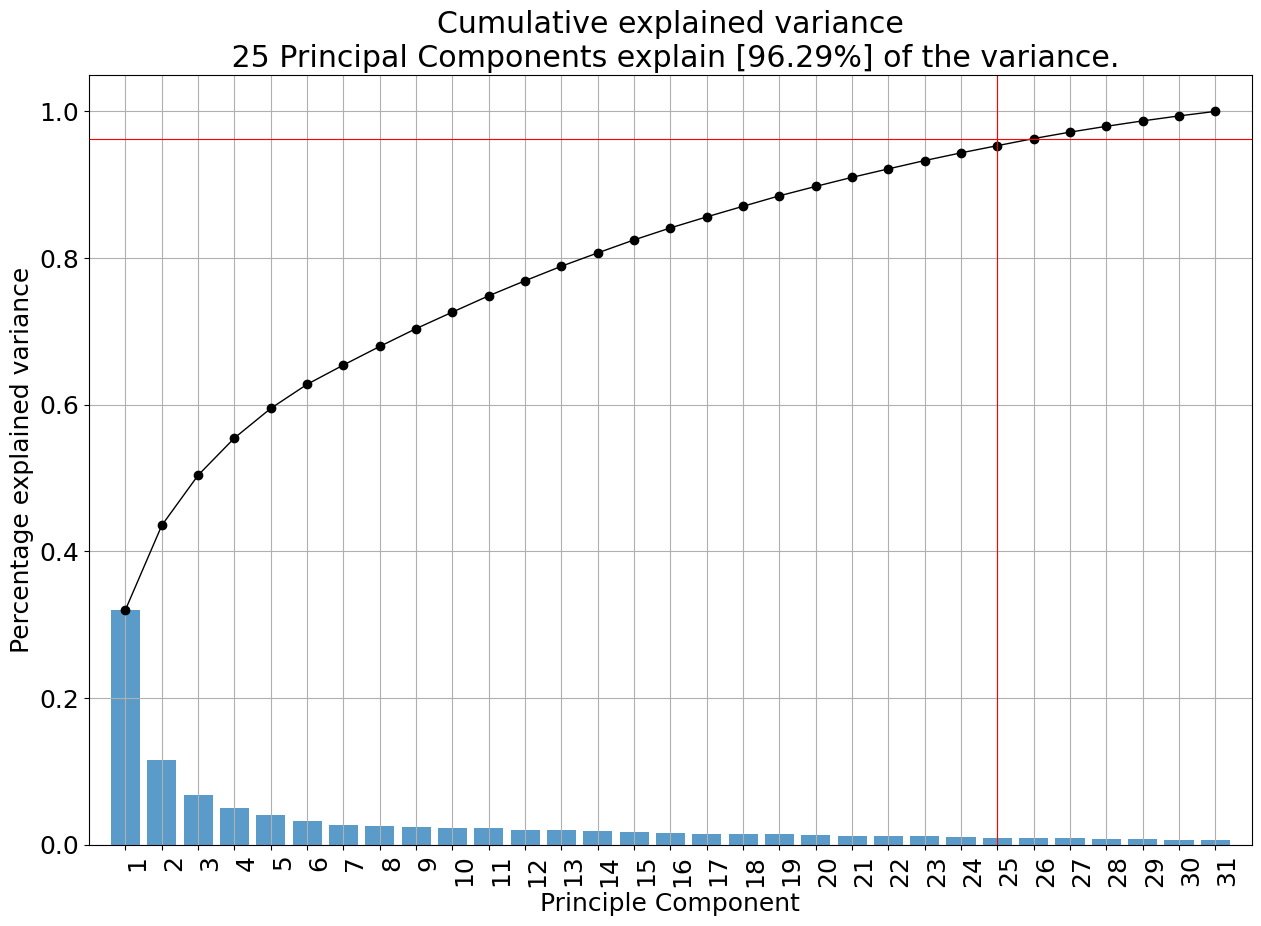

In [351]:
pca_new = pca()
out = pca_new.fit_transform(X_preprocessed, col_labels=X.columns.values, row_labels=y.values)
pca_new.plot()

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.


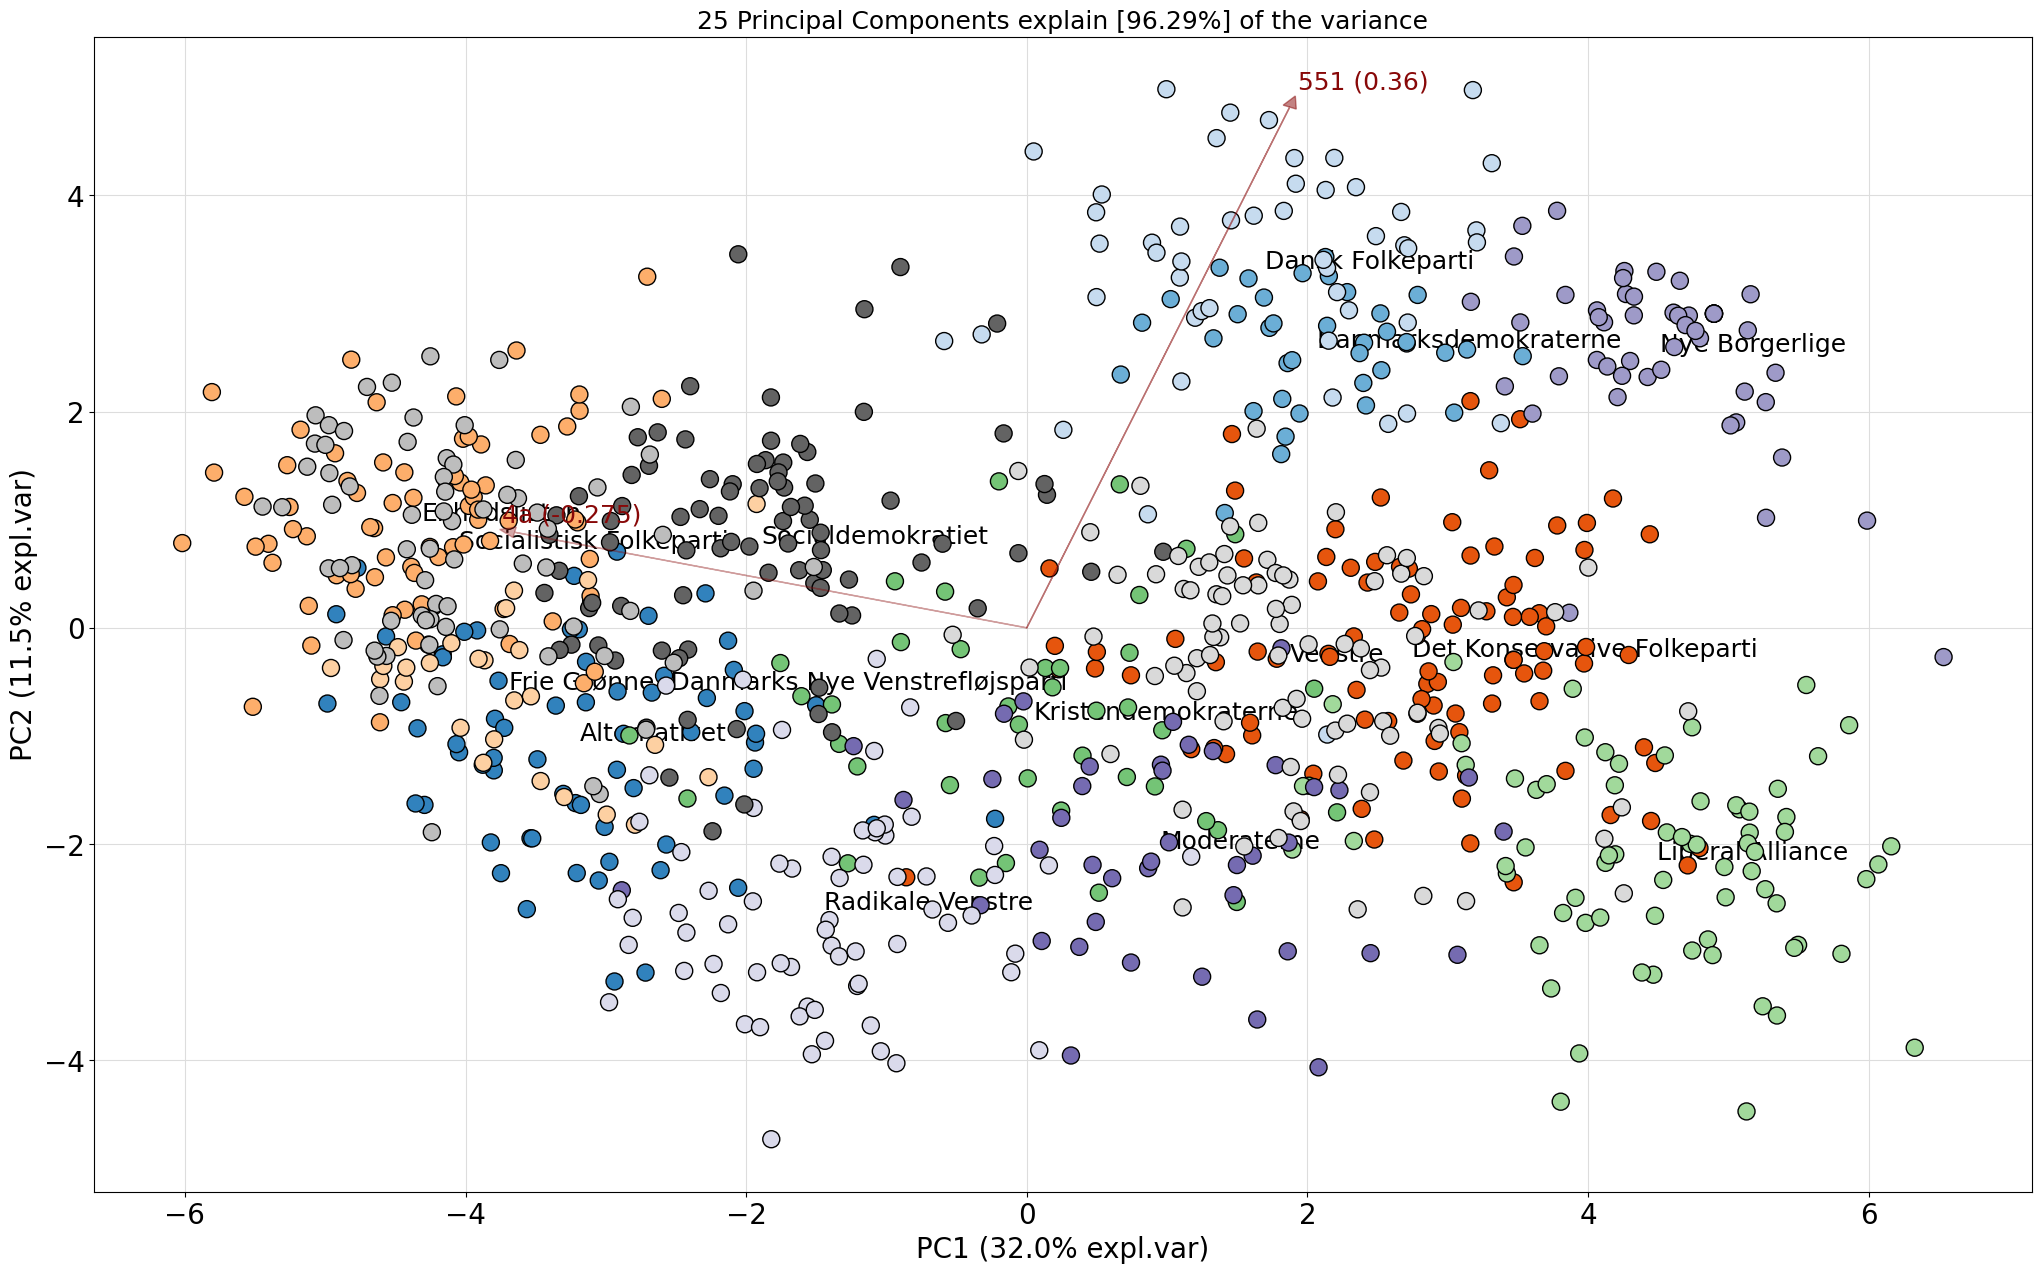

In [352]:
colors2 = [color_dictionary[parti] for parti in y.values]

ax = pca_new.biplot(n_feat=2, legend=False, c=colors2, alpha=1)

551 is imigration

4a is economy

## Average positions of parties per question